## Basic Setup and Cleaning

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set_theme() # set the default Seaborn style for graphics

KeyboardInterrupt: 

In [2]:
# Import dataset and check basic information
full_dataset = pd.read_csv('datasets/spotify_songs.csv')
print(full_dataset.shape)
# print(full_dataset.dtypes)
# full_dataset.head()
# full_dataset.describe()
full_dataset.info()

(32833, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  

From the printed `.info()` above, we can see that some of the records in the `full_dataset` contain `NA` values in certain variables. Hence, we drop those records from `full_dataset`.

In [3]:
# Apply the dropna() function to remove records with missing values
# then check the information of the cleaned dataset
full_dataset.dropna(inplace=True)
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32828 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32828 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32828 non-null  int64  
 4   track_album_id            32828 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32828 non-null  object 
 7   playlist_name             32828 non-null  object 
 8   playlist_id               32828 non-null  object 
 9   playlist_genre            32828 non-null  object 
 10  playlist_subgenre         32828 non-null  object 
 11  danceability              32828 non-null  float64
 12  energy                    32828 non-null  float64
 13  key                       32828 non-null  int64  
 14  loudness   

## Define the Popularity Levels

Since our goal is to roughly predict the popularity, we need to divide the `track_popularity` into several levels. To achieve this, let's perform some EDA and gain a general insight of this variable first.

       track_popularity
count      32828.000000
mean          42.483551
std           24.980476
min            0.000000
25%           24.000000
50%           45.000000
75%           62.000000
max          100.000000
track_popularity
0                   2698
1                    575
57                   541
60                   514
54                   514
                    ... 
97                    22
95                    15
96                     7
99                     4
100                    2
Name: count, Length: 101, dtype: int64


<Axes: >

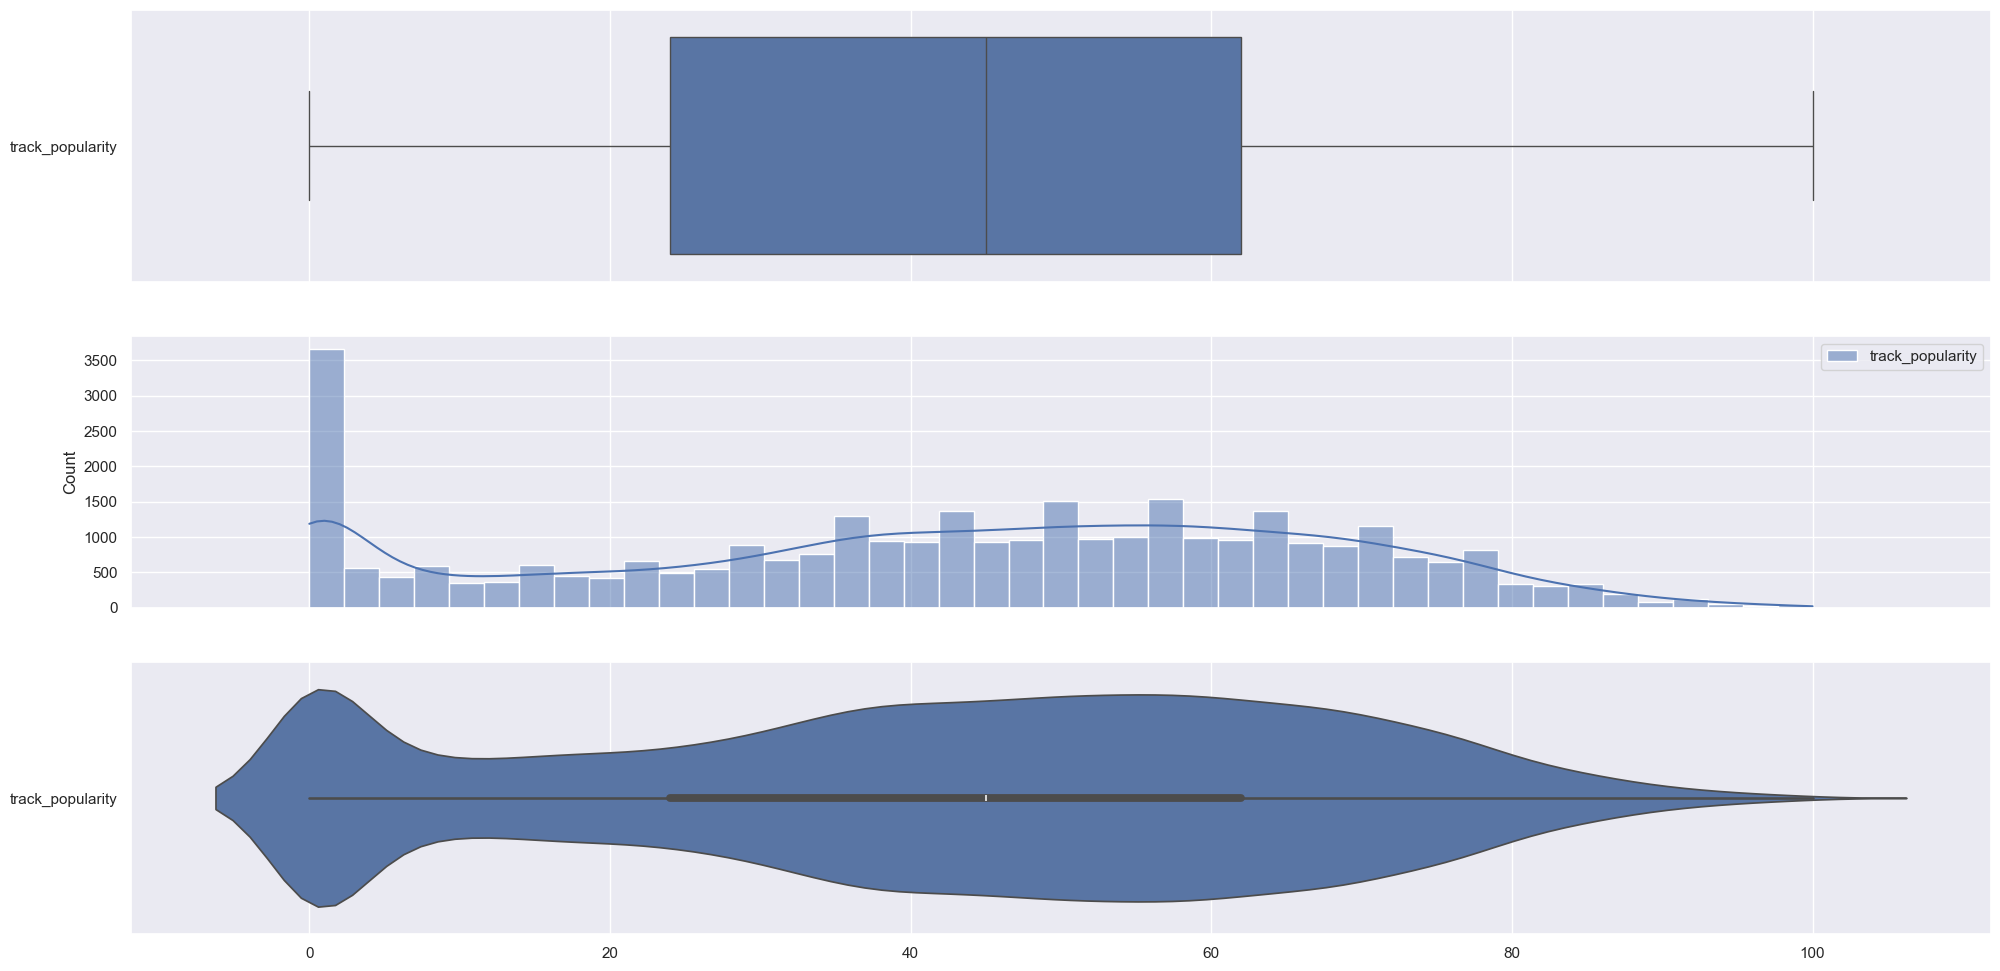

In [4]:
# Extract the track_popularity column and check its distribution
popularity = pd.DataFrame(full_dataset["track_popularity"])
print(popularity.describe())
print(popularity.value_counts())

f, axes = plt.subplots(3, 1, figsize=(24, 12), sharex=True)
sb.boxplot(data = popularity, orient = "h", ax=axes[0])
sb.histplot(data = popularity, kde = True, ax=axes[1])
sb.violinplot(data = popularity, orient = "h", ax=axes[2])

From the plots and `.value_counts()` above, we can see that there are unexpectedly high number of records with `track_popularity <= 1`. Let's assume this is a sort of anomaly and remove such records from our `full_dataset` to calculate a more credible mean and standard deviation.

Skewness of popularity: -0.23375042175196648
track_popularity
57     541
51     514
60     514
54     514
52     506
      ... 
97      22
95      15
96       7
99       4
100      2
Name: count, Length: 99, dtype: int64


<Axes: xlabel='track_popularity'>

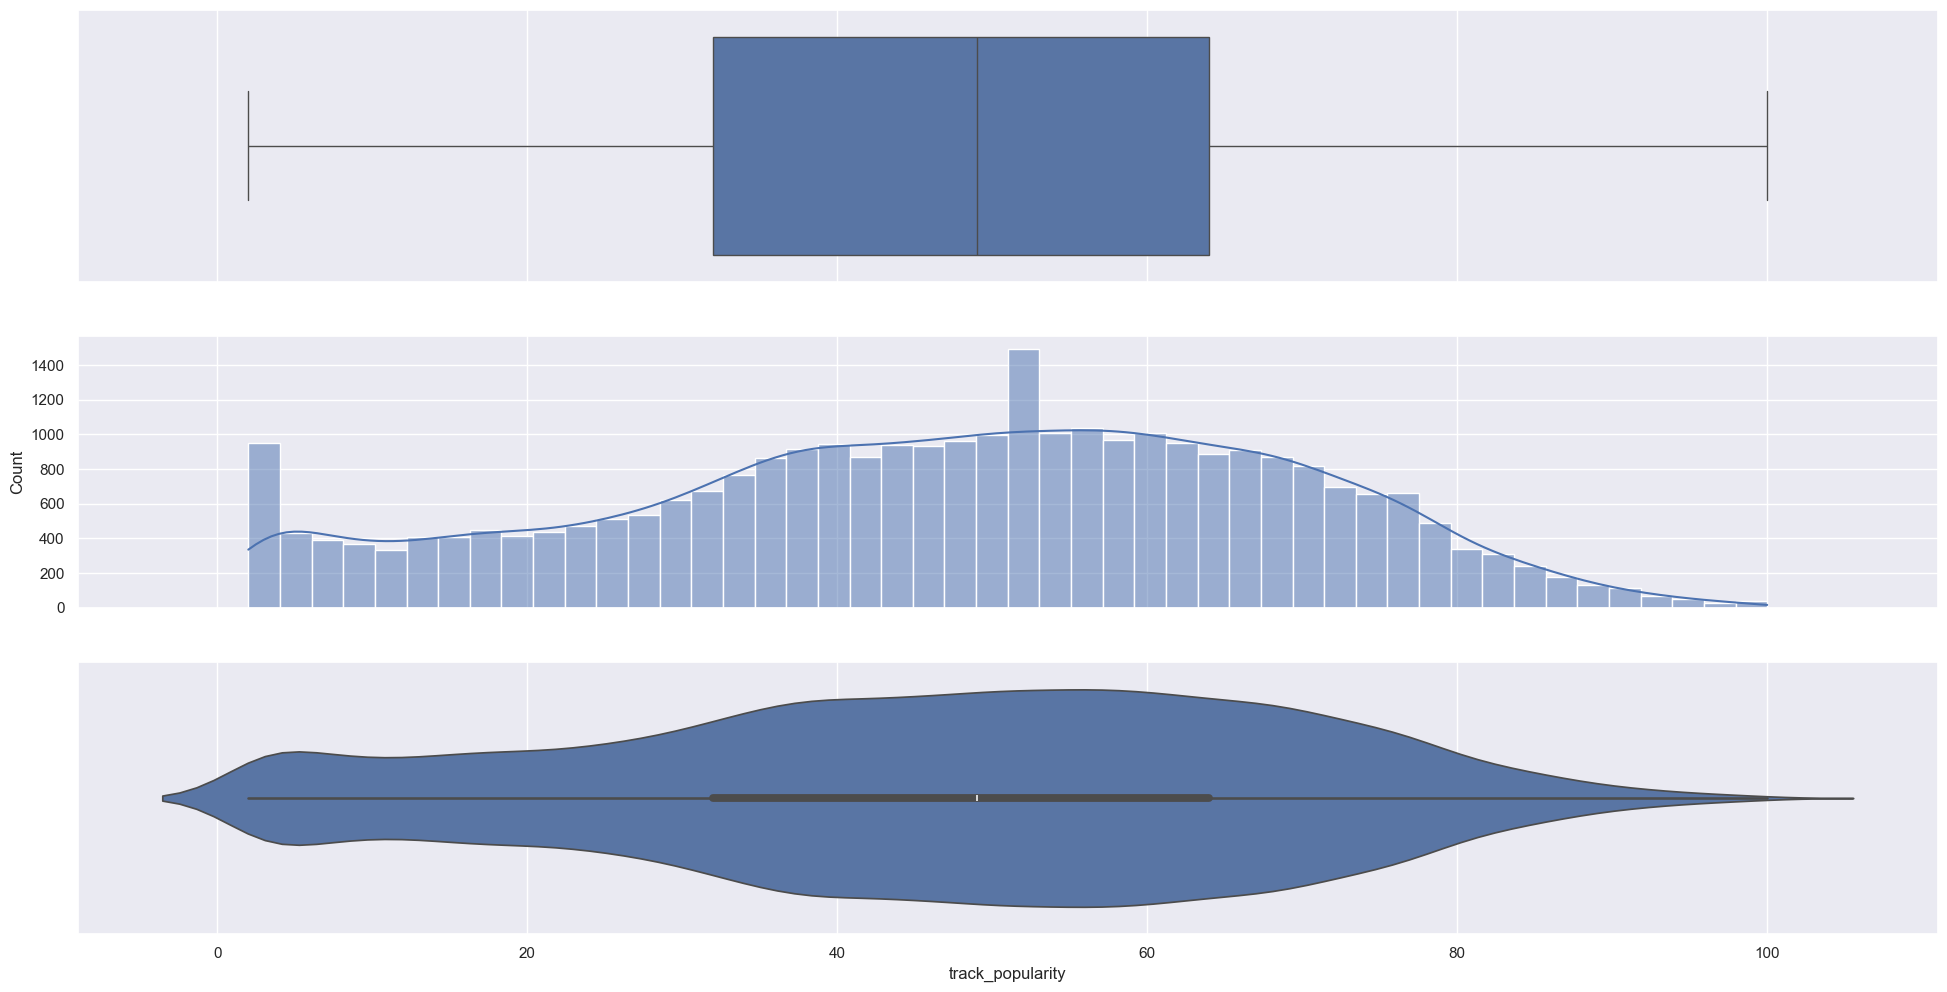

In [5]:
# Remove records whose value of popularity is lower than or equal to 1
full_dataset = full_dataset[full_dataset['track_popularity'] > 1]
popularity = full_dataset["track_popularity"]

# Check the skewness and distribution of the track_popularity column
from scipy.stats import skew

print("Skewness of popularity:", skew(popularity))
print(popularity.value_counts())
f, axes = plt.subplots(3, 1, figsize=(24, 12), sharex=True)
sb.boxplot(data = popularity, orient = "h", ax=axes[0])
sb.histplot(data = popularity, kde = True, ax=axes[1])
sb.violinplot(data = popularity, orient = "h", ax=axes[2])

From the calculated skewness and plots above, we can clearly see that **`track_popularity` is similar to a normal distribution** if we ignore the clustering phenomenon at the low end.

Thus, we can divide `track_popularity` into **6 levels** -- `very_low`, `low`, `somewhat_low`, `somewhat_high`, `high`, and `very_high` -- by mean and standard deviation.

In [6]:
# Calculate the mean and standard deviation of track_popularity
mean = popularity.mean()
std = popularity.std()

# Define the level divisions
very_low = mean - 2 * std
low = mean - std
medium = mean
high = mean + std
very_high = mean + 2 * std

# Create a new column "popularity_level" based on the level divisions
full_dataset["popularity_level"] = pd.cut(full_dataset["track_popularity"], bins=[0, very_low, low, medium, high, very_high, float('inf')], labels=["very_low", "low", "somewhat_low", "somewhat_high", "high", "very_high"])

# Check the distribution of popularity levels
popularity_level = pd.DataFrame(full_dataset["popularity_level"].value_counts(sort=False), columns=["count"])
popularity_level["density"] = popularity_level["count"] / len(full_dataset)
popularity_level

,count,density
popularity_level,,
very_low,708,0.023955
low,4591,0.155338
somewhat_low,8834,0.298900
somewhat_high,10145,0.343258
high,5025,0.170022
very_high,252,0.008526


## Reduce Sample Size

Currently the sample size is over 30k, and we choose to reduce it to 5k by random sampling.

In [46]:
sampled_dataset = full_dataset.sample(n=5000, random_state=29) # Use a random seed of 29 for reproducibility
# sampled_dataset.to_csv('datasets/cleaned_dataset.csv', index=False)
print(sampled_dataset.shape)
print(sampled_dataset["popularity_level"].value_counts(sort=False) / len(sampled_dataset))

(5000, 24)
popularity_level
very_low         0.0230
low              0.1458
somewhat_low     0.3060
somewhat_high    0.3446
high             0.1684
very_high        0.0122
Name: count, dtype: float64


## Perform EDA on the reduced sample

       track_popularity
count       5000.000000
mean          47.291800
std           21.552428
min            2.000000
25%           33.000000
50%           49.000000
75%           64.000000
max           99.000000
track_popularity
54                  109
51                   99
50                   98
49                   97
40                   96
                   ... 
94                    3
95                    3
96                    2
97                    2
99                    1
Name: count, Length: 98, dtype: int64


<Axes: >

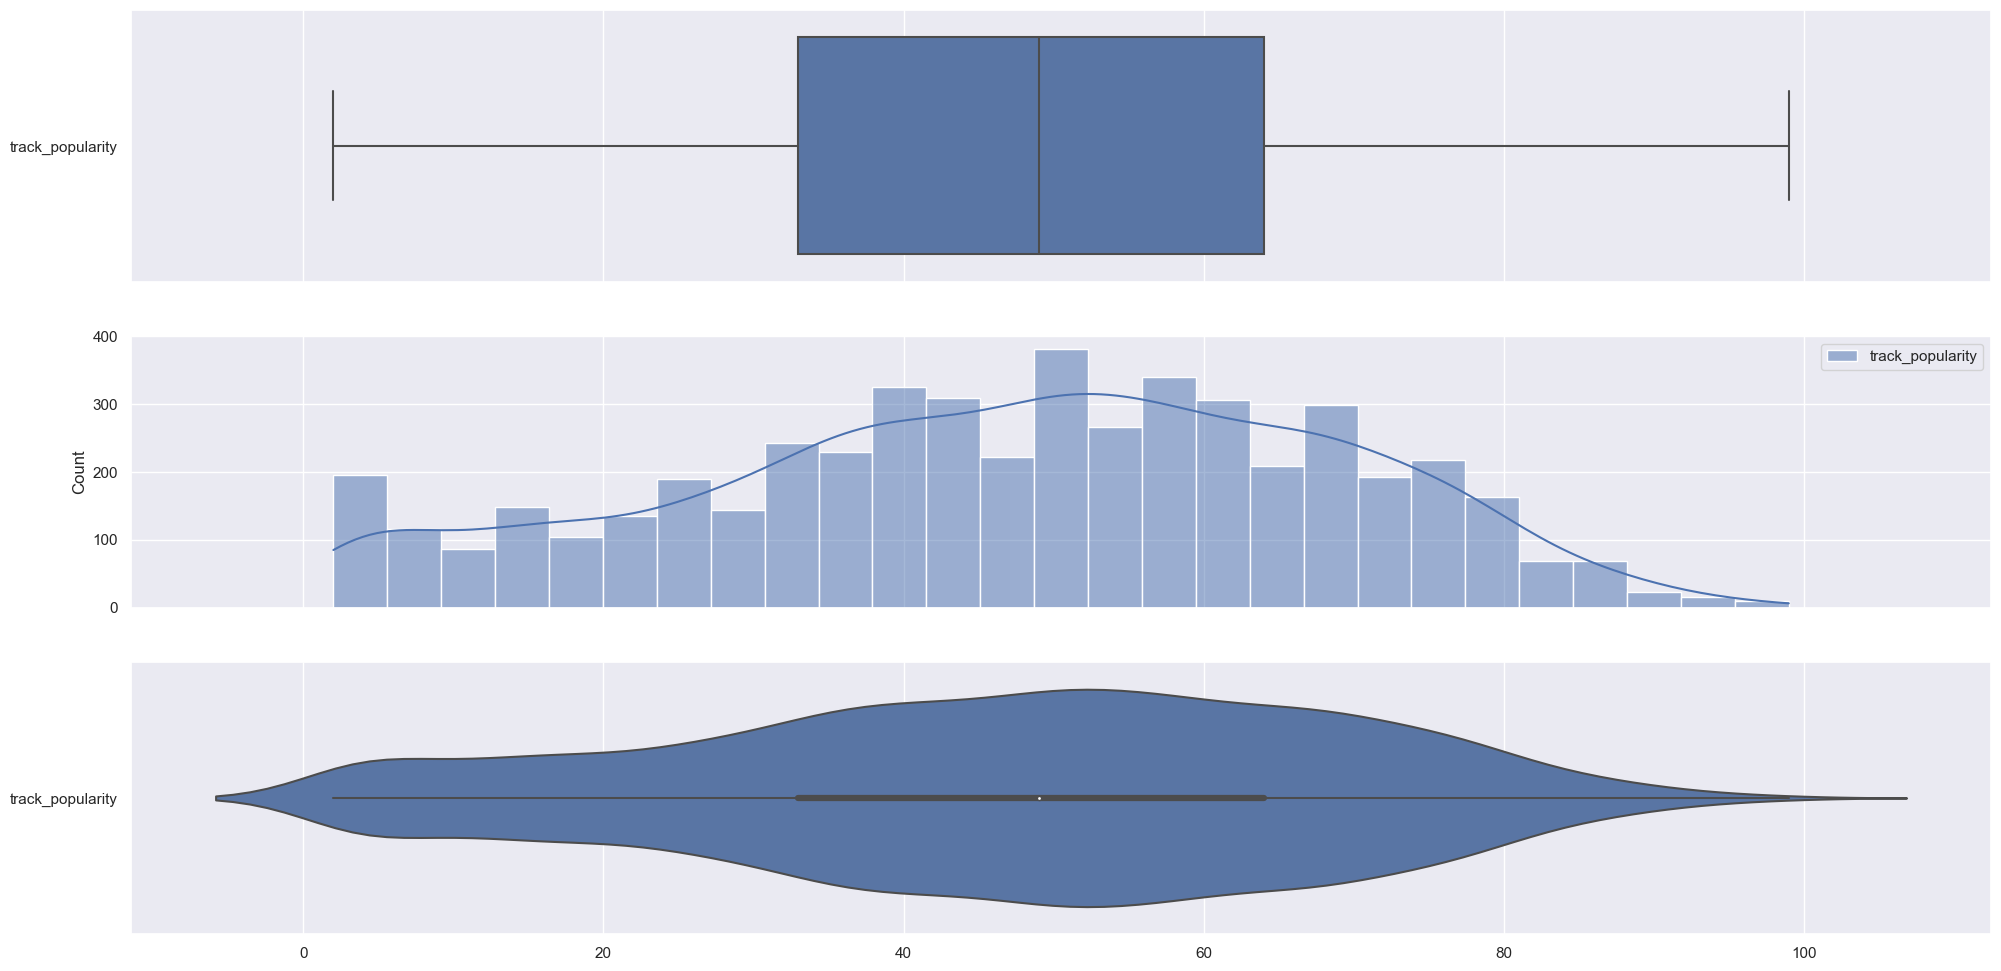

In [ ]:
popularity_1 = pd.DataFrame(sampled_dataset["track_popularity"])
print(popularity_1.describe())
print(popularity_1.value_counts())

f, axes = plt.subplots(3, 1, figsize=(24, 12), sharex=True)
sb.boxplot(data = popularity_1, orient = "h", ax=axes[0])
sb.histplot(data = popularity_1, kde = True, ax=axes[1])
sb.violinplot(data = popularity_1, orient = "h", ax=axes[2])